In [100]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pysindy as sindy

data = scipy.io.loadmat('DataHw3Q1.mat')

data.keys()

t = data['t'].T
x1 =data['x'][:,0]
x2 = data['x'][:,1]

nt = x1.shape[0]
split = int(0.8*nt)




if __name__ != "testing":
  t  = t.reshape(-1)[:split]
  x1 = x1[:split]
  x2 = x2[:split]
else:
  t  = t[split:]
  x1 = x1[split:]
  x2 = x2[split:]

In [101]:
#data matrix
data = np.vstack([x1, x2]).T

In [102]:
#define the library of potential functions

differentiation_method = sindy.FiniteDifference(order=2)

feature_library = sindy.PolynomialLibrary(degree=3)

feature_names = ["x", "y"]

optimizer = sindy.STLSQ(threshold = 0.1)

model = sindy.SINDy(
    differentiation_method=differentiation_method,
    feature_library= feature_library,
    optimizer= optimizer,
    feature_names = feature_names
)

In [103]:
model.fit(data, t=t)
print("The required system of equations:")
model.print()


The required system of equations:
(x)' = 0.499 1 + 0.998 x + -0.998 y + -0.333 x^3
(y)' = 0.200 x + -0.160 y


Question 2: Encoder vs DMD

In [104]:
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras import layers
import matplotlib.pyplot as plt
import os
import numpy as np

K.clear_session()

Variational AutoEncoder for Compressed Sensing

In [105]:
H = 32 #Height
W = 32 #Width
C = 1  #Channels
L = 2 #Latent dimensionality

In [106]:
# The way to complie z_mean and z_log_var
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))  # standarnd normal distribution as default, with mean=0 and std=1.0
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [107]:
## Try larger strides and kernel and more CNN layer to make sure when it is flatten the parameter wont be too much !
def Encoder_VAE():
    encoder_inputs = keras.Input(name="Encoder_inputs",shape = (H,W,C))

    x = layers.Conv2D(32,(3,3),strides=(2,2),padding ="same",name= "conv1")(encoder_inputs)


    x = layers.Conv2D(64,(3,3),strides=(2,2),padding ="same",name= "conv2")(x)


    #x = layers.Conv2D(64,(3,3),strides=(2,2),padding ="same",name= "conv3")(x)



    x = layers.Flatten()(x)
    x = layers.Dense(16,activation = "relu")(x) #apply relu activation function
    z_mean = layers.Dense(L,name= "z_mean")(x)
    z_log_var = layers.Dense(L,name="z_log_var")(x)

    z = layers.Lambda(sampling, output_shape=(L,), name='z')([z_mean, z_log_var])

    return keras.Model(inputs =encoder_inputs,outputs=[z_mean,z_log_var],name="encoder")

In [108]:
Encoder = Encoder_VAE()
Encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder_inputs (InputLayer  [(None, 32, 32, 1)]          0         []                            
 )                                                                                                
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 32)           320       ['Encoder_inputs[0][0]']      
                                                                                                  
 conv2 (Conv2D)              (None, 8, 8, 64)             18496     ['conv1[0][0]']               
                                                                                                  
 flatten (Flatten)           (None, 4096)                 0         ['conv2[0][0]']         

In [109]:
class Sampler(layers.Layer):
 def call(self,z_mean,z_log_var):
    batch_size = tf.shape(z_mean)[0]
    z_size = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch_size,z_size))

    return z_mean + tf.exp(0.5*z_log_var)*epsilon

Decoder: Mapping the the latent space, of dimension 2, into images in this case, flow modes

In [110]:
def Decoder_VAE():
  latent_inputs= layers.Input(shape=(L,),name="latent_input")

  x= layers.Dense(8*8*64,activation="relu",name="decoder_dense1")(latent_inputs)

  x = layers.Reshape((8,8,64))(x)

  x = layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding="same",activation="relu",name="decoder_1")(x)
  x = layers.Conv2DTranspose(32,(3,3),strides=(2,2),padding="same",activation="relu",name="decoder_2")(x)

  #x = layers.Conv2DTranspose(32,(5,5),strides=(2,2),padding="same",activation="relu",name="decoder_3")(x)



  decoder_outputs = layers.Conv2D(C,(3,3),padding="same")(x)
  return keras.Model(latent_inputs,decoder_outputs,name="decoder")

In [111]:
Decoder = Decoder_VAE()
Decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_input (InputLayer)   [(None, 2)]               0         
                                                                 
 decoder_dense1 (Dense)      (None, 4096)              12288     
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 decoder_1 (Conv2DTranspose  (None, 16, 16, 64)        36928     
 )                                                               
                                                                 
 decoder_2 (Conv2DTranspose  (None, 32, 32, 32)        18464     
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 1)         289 

In [112]:
class VAE(keras.Model):
  def __init__(self,encoder,decoder,**kwargs):
    super().__init__(**kwargs)
    self.encoder = Encoder
    self.decoder = Decoder
    self.sampler = Sampler()
    self.total_loss_tracker = keras.metrics.Mean(name="total_ oss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl loss")

  @property
  def metrics(self):
    return [
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker
        ]

  def train_step(self,data):
    # Gradient Descent Back Propagation
    with tf.GradientTape() as tape:
      z_mean,z_log_var = self.encoder(data)
      z = self.sampler(z_mean,z_log_var)
      reconstruction = Decoder(z)

      reconstruction_loss = tf.reduce_mean(
                          tf.reduce_sum(
                              keras.losses.mae(data, reconstruction),
                              axis = (1,2))
                          )

      kl_loss = -0.5 * (1 + z_log_var -tf.square(z_mean) - tf.exp(z_log_var) )

      total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
    grads = tape.gradient(total_loss,self.trainable_weights)

    # Update gradients descent for optimize the parameters
    self.optimizer.apply_gradients( zip(grads,self.trainable_weights) )

    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)


    return {
        "total_loss":self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result()
    }

In [114]:
def Data(N):
    y = np.linspace(-2,2,H) # spatial coordinate
    Ny = np.size(y)

    amp1 = 1
    y01 = 0.5
    sigmay1 = 0.6

    amp2 = 1.2
    y02 = -0.5
    sigmay2 = 0.3

    dt = 0.1
    Nt = 32
    tend = dt*(Nt-1)
    t = np.linspace(0,tend,Nt) # time
    X_all = np.zeros(shape=(N,Ny,Nt))

    for i in range(N):

        omega1 = np.random.randint(1,2,size=1)+np.random.rand(1)

        omega2 = np.random.randint(4,5,size=1)+np.random.rand(1)

        v1 = amp1*np.exp(-((y-y01)**2)/(2*sigmay1**2))
        v2 = amp2*np.exp(-((y-y02)**2)/(2*sigmay2**2))

        X = np.zeros([Ny,Nt],dtype=complex)
        for tt in range(Nt):
            X[:,tt] = v1*np.exp(1j*omega1*t[tt])+v2*np.exp(1j*omega2*t[tt]) 
                
        X = (X-X.min())/(X.max()-X.min())
        X_all[i,:,:] = X
    
    X_all = np.expand_dims(X_all,axis=-1)

    return X_all

############################################################################################
# -------------------- 2D CONTOURS
############################################################################################

/tmp/ipykernel_519838/937327612.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  X_all[i,:,:] = X


Shape of Dataset is (10000, 32, 32, 1)


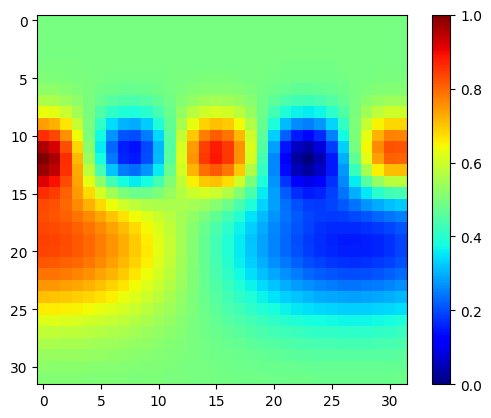

In [115]:
data = Data(10000)
print(f"Shape of Dataset is {data.shape}")

imh = plt.imshow(data[0,:,:,0],cmap="jet")
plt.colorbar(imh)

TRAIN VAE

In [116]:
K.clear_session()

encoder = Encoder_VAE()
decoder = Decoder_VAE()

vae = VAE(encoder,decoder)

vae.compile(optimizer=keras.optimizers.Adam(0.001))

In [117]:
def scheduler(epoch, lr):
  if lr > 1e-4:
    return lr * 0.0001**(epoch/5000)
  else:
    return lr

callbacks = [keras.callbacks.LearningRateScheduler(scheduler)]

In [118]:
history = vae.fit(data,epochs=100,batch_size=64,verbose = 1)


Epoch 1/100
157/157 [==============================] - 12s 65ms/step - total_loss: 167.0984 - reconstruction_loss: 162.5018 - kl_loss: 4.5966
Epoch 2/100
157/157 [==============================] - 10s 63ms/step - total_loss: 71.3656 - reconstruction_loss: 31.1909 - kl_loss: 2.5901
Epoch 3/100
157/157 [==============================] - 10s 63ms/step - total_loss: 50.0901 - reconstruction_loss: 12.8385 - kl_loss: 3.0584
Epoch 4/100
157/157 [==============================] - 9s 56ms/step - total_loss: 39.8457 - reconstruction_loss: 10.7013 - kl_loss: 3.1166
Epoch 5/100
157/157 [==============================] - 9s 56ms/step - total_loss: 33.3730 - reconstruction_loss: 6.9976 - kl_loss: 3.2923
Epoch 6/100
157/157 [==============================] - 9s 55ms/step - total_loss: 29.2199 - reconstruction_loss: 7.0226 - kl_loss: 3.3004
Epoch 7/100
157/157 [==============================] - 9s 56ms/step - total_loss: 26.5415 - reconstruction_loss: 9.4174 - kl_loss: 3.2007
Epoch 8/100
157/157 [====

In [ ]:
import pandas as pd
history_df= pd.DataFrame(history.history)
history_df.to_csv("300epoch_64_history.csv")
history_df.plot()

vae.encoder.save("Weights/Encoder_300_64.h5")
vae.decoder.save("Wegiths/Decoder_300_64.h5")
vae.encoder.save_weights("Weights/ncoder_300_64_weights.h5")
vae.decoder.save_weights("Weights/Decode_300_64_weights.h5")